## **리니지** 고객(유저) 활동 데이터를 활용하여 잔존 가치를 고려한 **이탈 예측** 모형 개발
---
> ## < CONTENTS >
> ### Step1. 데이터 탐사 분석
> ### Step2. 데이터 전처리
> ### Step3. 모델 선택 및 구축
> ### Step4. 모델 개선

# Step1. 데이터 탐사 분석

## 1-1. 데이터 호출

In [69]:
path = r'C:\Users\student\Desktop\2019빅콘테스트_챔피언스리그/'
data_name = 'train' #or 'test1' or test2
trade = pd.read_csv(path +data_name+'_trade.csv')
pledge = pd.read_csv(path +data_name+'_pledge.csv')
payment = pd.read_csv(path +data_name+'_payment.csv')
combat = pd.read_csv(path +data_name+'_combat.csv')
activity = pd.read_csv(path +data_name+'_activity.csv')

print('='*10, 'trade data 요약', '='*10)
print(trade.info())
print()
print('='*10, 'pledge data 요약', '='*10)
print( pledge.info())
print()
print('='*10, 'payment data 요약', '='*10)
print(payment.info())
print()
print('='*10, 'combat data 요약', '='*10)
print(combat.info())
print()
print('='*10, 'activity data 요약', '='*10)
print(activity.info())

========== trade data 요약 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1849325 entries, 0 to 1849324
Data columns (total 11 columns):
day               int64
time              object
type              int64
server            object
source_acc_id     int64
source_char_id    int64
target_acc_id     int64
target_char_id    int64
item_type         object
item_amount       float64
item_price        float64
dtypes: float64(2), int64(6), object(3)
memory usage: 155.2+ MB
None

========== pledge data 요약 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083384 entries, 0 to 1083383
Data columns (total 15 columns):
day                     1083384 non-null int64
acc_id                  1083384 non-null int64
char_id                 1083384 non-null int64
server                  1083384 non-null object
pledge_id               1083384 non-null int64
play_char_cnt           1083384 non-null float64
combat_char_cnt         1083384 non-null float64
pledge_combat_cnt       10

## 1-2. 상관관계 분석 시각화
데이터 파악을 위해 각 테이블 내에서 상관관계를 러프하게 분석 후 시각화

================================================== trade ==================================================


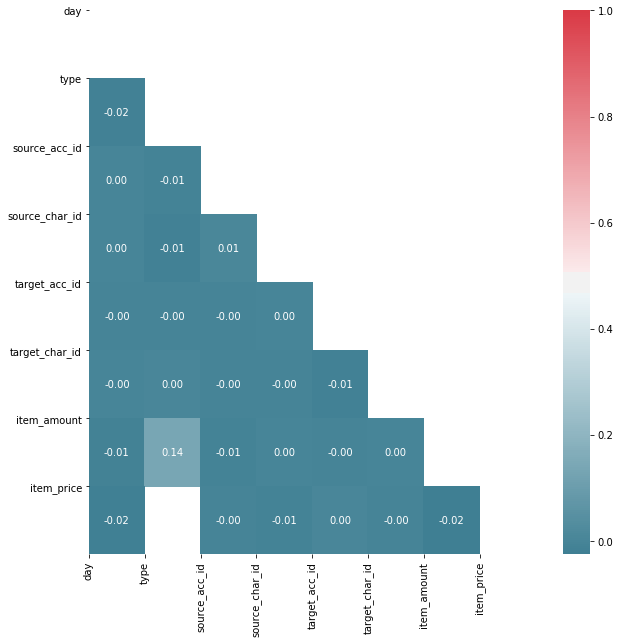

None
================================================== pledge ==================================================


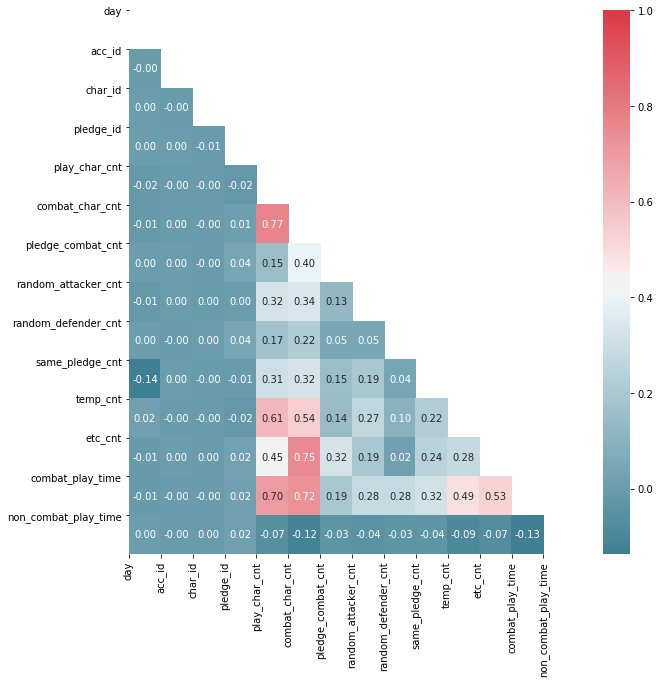

None
================================================== combat ==================================================


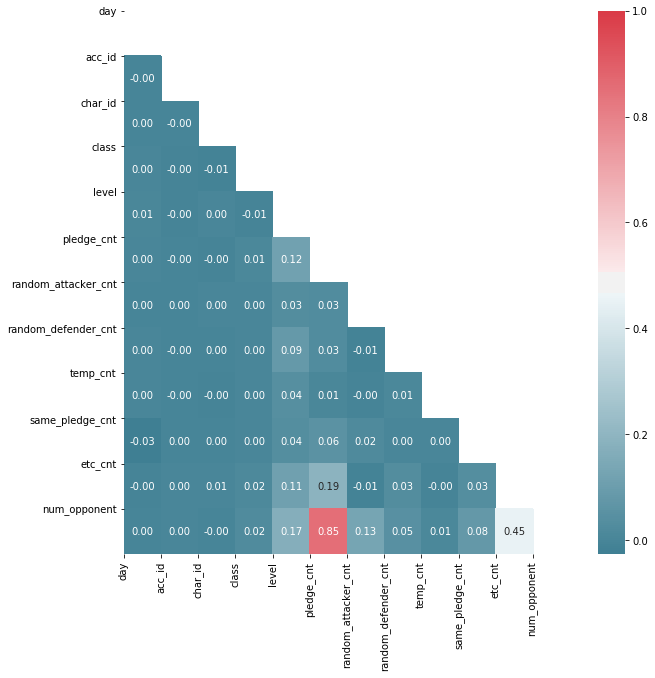

None
================================================== activity ==================================================


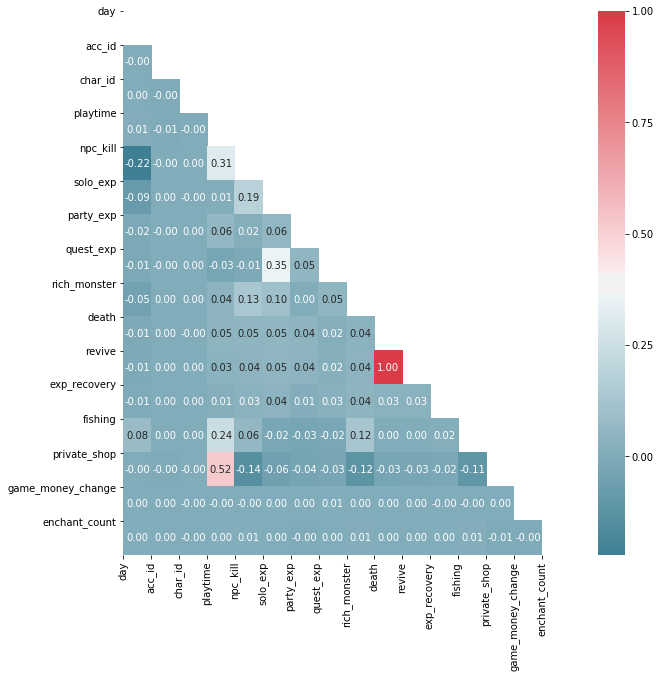

None


In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def show_plot(rawDf):
    df = rawDf.copy()
    # Create Correlation df
    corr = df.corr()
    # Plot figsize
    fig, ax = plt.subplots(figsize=(10, 10))
    # Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)

    # Drop self-correlations
    dropSelf = np.zeros_like(corr)
    dropSelf[np.triu_indices_from(dropSelf)] = True
    # Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    # Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
    # Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    # Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    # show plot
    print(plt.show())
print('='*50,'trade','='*50)
show_plot(trade)
print('='*50,'pledge','='*50)
show_plot(pledge)
print('='*50,'combat','='*50)
show_plot(combat)
print('='*50,'activity','='*50)
show_plot(activity)

## Step2. 데이터 전처리
각 테이블 내에서 상관관계를 러프하게 분석한 결과, 대부분의 테이블 내 변수끼리의 상관관계가 낮게 나옴  
비슷한 상관도를 가진 feature를 drop 시키는 것은 의미가 없다고 판단  
이에 대부분의 자료를 가시적인 scalar 값을 가지도록 차원 축소를 하자고 결정  
(*예를 들어, 한 계정에서 123,456,789 라는 캐릭터 아이디를 각각 사용했을 때, 그 계정이 사용한 캐릭터의 개수(=3)로 차원을 축소하는 방향*)

## 2-1. 분석을 위한 기본 틀 생성

In [32]:
# 데이터 내에 존재하는 아이디를 추출하고 각각의 아이디에서 28 days의 행을 생성하여 데이터를 넣을 기본 틀 완성 
unique = activity.acc_id.unique()
acc_id_lst = sorted(list(unique)*28)
day_lst = (list(range(1,29))*len(unique))
full_acc_id_day = pd.DataFrame({'acc_id' : acc_id_lst, 'day' : day_lst})
full_acc_id_day

,acc_id,day
0,2,1
1,2,2
2,2,3
3,2,4
4,2,5
5,2,6
6,2,7
7,2,8
8,2,9
9,2,10


## 2-2. 각 테이블 전처리
###  - activity테이블 전처리

In [33]:
# 각 계정 당 하루치 활동을 모두 더하기
new_activity = activity.sort_values(by=['acc_id','day'])
new_activity.index = range(len(new_activity))
new_activity = new_activity[['acc_id','day'] + list(new_activity.columns)[2:]]
activity_result = new_activity.groupby(['acc_id','day']).sum()

# 하나의 계정에서 하루에 활동했던 총 캐릭터 아이디 개수 구하기
activity_result['char_id'] = new_activity.drop_duplicates(['acc_id','day','char_id']).groupby(['acc_id','day']).char_id.count()

# 하나의 계정에서 하루에 활동했던 총 서버 아이디 개수 구하기
activity_result['server'] = new_activity.drop_duplicates(['acc_id','day','server']).groupby(['acc_id','day']).server.count()

# 테이블 정리
activity_result = activity_result.reset_index()
activity_result = activity_result[['acc_id','day','char_id','server'] + list(activity_result.columns[3:-1])]
activity_result = activity_result.rename(columns={'char_id' : 'activity_char_cnt',
                                                  'server' : 'activity_server_cnt'})
# 각 계정 당 하루에 가장 playtime이 긴 캐릭터 아이디 구하기
charId= new_activity.sort_values(['acc_id','day','playtime']).groupby(['acc_id','day']).last().char_id.reset_index()
activity_result['max_char_id'] = charId['char_id']
activity_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949358 entries, 0 to 949357
Data columns (total 18 columns):
acc_id                 949358 non-null int64
day                    949358 non-null int64
activity_char_cnt      949358 non-null int64
activity_server_cnt    949358 non-null int64
playtime               949358 non-null float64
npc_kill               949358 non-null float64
solo_exp               949358 non-null float64
party_exp              949358 non-null float64
quest_exp              949358 non-null float64
rich_monster           949358 non-null int64
death                  949358 non-null float64
revive                 949358 non-null float64
exp_recovery           949358 non-null float64
fishing                949358 non-null float64
private_shop           949358 non-null float64
game_money_change      949358 non-null float64
enchant_count          949358 non-null float64
max_char_id            949358 non-null int64
dtypes: float64(12), int64(6)
memory usage: 130.4 MB


### - Trade 테이블 전처리

In [36]:
# 반복적 작업이 있어서 class 생성
class TradePre:
    def __init__(self, tradeData, actData):
        self.trade = tradeData
        self.act = actData
        self.key = self.act[['acc_id', 'day', 'max_char_id']]

    def count(self, day):
        count = self.trade[self.trade['day']==day].acc_id.value_counts()
        key_cnt = self.key[self.key['day']==day]
        df = pd.merge(key_cnt, pd.DataFrame({'acc_id':list(count.keys()), 'count':count}))
        return df
    
    def amount(self, day):
        df = self.trade[self.trade['day']==day].groupby('acc_id')\
        .apply(lambda x:pd.Series({'day':day, 
                                   'amount': sum(x.item_amount), 
                                   'price': sum(x.item_price)})).reset_index()
        return df

    def concat(self, func):
        df = pd.concat(list(map(lambda x: func(x), range(1,29))))
        return df

#### 대가성 거래 데이터 : item_price != None

In [37]:
trade_origin = trade.copy()

# 대가성 거래 데이터만 추출
tradeData = trade_origin.dropna()

sell_tradeData = tradeData.rename(columns = {'source_acc_id':'acc_id','source_char_id':'char_id'})
buy_tradeData = tradeData.rename(columns = {'target_acc_id':'acc_id', 'target_char_id':'char_id'})

# 앞서 작성한 'TradePre' class를 사용하여 인스턴스 생성
sell = TradePre(sell_tradeData,activity_result)
buy = TradePre(buy_tradeData,activity_result)

# 앞서 작성한 'TradePre' class의 함수를 사용하여 필요한 정보 추출
# 한 계정에서 하루에 판 총 횟수 구하기
sell_cnt = sell.concat(sell.count)
# 한 계정에서 하루에 판매한 아이템의 총량 구하기
sell_amount = sell.concat(sell.amount)
# 한 계정에서 하루에 총 산 횟수 구하기
buy_cnt = buy.concat(buy.count)
# 한 계정에서 하루에 구매한 아이템의 총량 구하기
buy_amount = buy.concat(buy.amount)

# 데이터 병합 및 정렬
sellDf = sell_cnt.merge(sell_amount)
buyDf = buy_cnt.merge(buy_amount)
sellDf = sellDf.rename(columns ={'count':'sell_cnt', 'amount':'sell_amount','price':'sell_price'})
buyDf = buyDf.rename(columns ={'count':'buy_cnt', 'amount':'buy_amount','price':'buy_price'})
trDf = pd.merge(sellDf, buyDf, how = 'outer')
trDf.head()

,acc_id,day,max_char_id,sell_cnt,sell_amount,sell_price,buy_cnt,buy_amount,buy_price
0,2,1,233598,6.0,2.732562e-06,3.456524,NaN,NaN,NaN
1,50,1,78995,5.0,1.102613e-05,0.234030,NaN,NaN,NaN
2,59,1,394351,1.0,4.793968e-08,0.002594,NaN,NaN,NaN
3,65,1,270517,3.0,9.827634e-07,0.313629,NaN,NaN,NaN
4,79,1,225036,11.0,1.701859e-06,0.714167,NaN,NaN,NaN


#### 대가가 없는 데이터 : item_price == None

In [38]:
# price가 없는 데이터일 경우 단순한 거래가 아닌 아이템 옮기기나 교환 등의 행위일 수 있다고 판단하여 따로 처리
exchangeData = trade_origin[pd.isna(trade_origin['item_price'])]

give_tradeData = exchangeData.rename(columns = {'source_acc_id':'acc_id','source_char_id':'char_id'})
get_tradeData = exchangeData.rename(columns = {'target_acc_id':'acc_id', 'target_acc_id':'acc_id'})

# 앞서 작성한 'TradePre' class를 사용하여 인스턴스 생성
give = TradePre(give_tradeData,activity_result)
get = TradePre(get_tradeData,activity_result)
# 한 계정에서 하루에 아이템을 준 총 횟수 구하기
give_cnt = give.concat(give.count)
# 한 계정에서 하루에 준 아이템의 총량 구하기
give_amount = give.concat(give.amount)
# 한 계정에서 하루에 아이템을 받은 총 횟수 구하기
get_cnt = get.concat(get.count)
# 한 계정에서 하루에 받은 아이템의 총량 구하기
get_amount = get.concat(get.amount)

# 데이터 병합 및 정렬
giveDf = give_cnt.merge(give_amount) 
getDf = get_cnt.merge(get_amount) 
giveDf = giveDf.rename(columns ={'count':'give_cnt', 'amount':'give_amount','price':'give_price'})
getDf = getDf.rename(columns ={'count':'get_cnt', 'amount':'get_amount','price':'get_price'})
exDf = pd.merge(giveDf, getDf, how = 'outer')
exDf.head()

,acc_id,day,max_char_id,give_cnt,give_amount,give_price,get_cnt,get_amount,get_price
0,20,1,149667,1.0,2.396984e-08,NaN,1.0,2.396984e-08,NaN
1,43,1,388134,1.0,3.595476e-02,NaN,NaN,NaN,NaN
2,53,1,60446,1.0,7.622409e-06,NaN,1.0,7.190952e-03,NaN
3,62,1,369719,2.0,9.084569e-01,NaN,4.0,1.078643e+00,NaN
4,65,1,270517,8.0,2.259837e+00,NaN,3.0,1.271329e+00,NaN


In [39]:
trade_result = trDf.sort_values(['acc_id','day']).reset_index(drop=True)
exchange_result = exDf.sort_values(['acc_id','day']).reset_index(drop=True)
print('='*10, 'trade_result 요약', '='*10)
print(trade_result.info())
print()
print('='*10, 'exchange_result 요약', '='*10)
print(exchange_result.info())

========== trade_result 요약 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241799 entries, 0 to 241798
Data columns (total 9 columns):
acc_id         241799 non-null int64
day            241799 non-null int64
max_char_id    241799 non-null int64
sell_cnt       92685 non-null float64
sell_amount    92685 non-null float64
sell_price     92685 non-null float64
buy_cnt        154613 non-null float64
buy_amount     154613 non-null float64
buy_price      154613 non-null float64
dtypes: float64(6), int64(3)
memory usage: 16.6 MB
None

========== exchange_result 요약 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230455 entries, 0 to 230454
Data columns (total 9 columns):
acc_id         230455 non-null int64
day            230455 non-null int64
max_char_id    230455 non-null int64
give_cnt       190417 non-null float64
give_amount    190417 non-null float64
give_price     0 non-null float64
get_cnt        187711 non-null float64
get_amount     187711 non-null float64
g

### - combat 데이터 전처리

In [40]:
key = activity[['acc_id', 'day', 'char_id','playtime']]

# 각 계정 당 하루치 전투 데이터를 모두 더하기
combatDf = combat.groupby(['acc_id','day']).sum().reset_index()

# 하나의 계정에서 하루에 활동했던 총 캐릭터 아이디 개수 구하기
combat_char_cnt = combat.drop_duplicates(['acc_id','day','char_id'])\
.groupby(['acc_id','day']).char_id.count().reset_index().rename(columns = {'char_id':'combat_char_cnt'})

# 하나의 계정에서 하루에 활동했던 총 서버 개수 구하기
combat_server_cnt = combat.drop_duplicates(['acc_id','day','server'])\
.groupby(['acc_id','day']).server.count().reset_index().rename(columns = {'server':'combat_server_cnt'})

# 하나의 계정에서 하루에 활동했던 캐릭터들 중 playtime이 가장 긴 캐릭터의 레벨 구하기
level = combat.sort_values(['acc_id','day','level']).groupby(['acc_id','day']).last().level.reset_index().rename(columns = {'level':'max_level'})

# 데이터 병합 및 정렬
combatDf = combatDf.merge(combat_char_cnt, how = 'left', on = ['acc_id', 'day'])
combatDf = combatDf.merge(combat_server_cnt, how = 'left', on = ['acc_id', 'day'])
combatDf = combatDf.merge(level, how = 'left', on = ['acc_id', 'day'])
del combatDf['char_id']

combat_result = combatDf[['acc_id','day']+list(combatDf.columns)[-3:]+list(combatDf.columns)[4:-3]]\
.rename(columns={'random_attacker_cnt':'combat_random_attacker_cnt',
                 'random_defender_cnt':'combat_random_defender_cnt',
                 'temp_cnt':'combat_temp_cnt',
                 'same_pledge_cnt':'combat_same_pledge_cnt',
                 'etc_cnt':'combat_etc_cnt'})
combat_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 945628 entries, 0 to 945627
Data columns (total 12 columns):
acc_id                        945628 non-null int64
day                           945628 non-null int64
combat_char_cnt               945628 non-null int64
combat_server_cnt             945628 non-null int64
max_level                     945628 non-null int64
pledge_cnt                    945628 non-null float64
combat_random_attacker_cnt    945628 non-null float64
combat_random_defender_cnt    945628 non-null float64
combat_temp_cnt               945628 non-null float64
combat_same_pledge_cnt        945628 non-null float64
combat_etc_cnt                945628 non-null float64
num_opponent                  945628 non-null float64
dtypes: float64(7), int64(5)
memory usage: 93.8 MB


### - pledge테이블 처리

In [41]:
new_pledge = pledge.sort_values(by=['acc_id','day'])
new_pledge.index = range(len(new_pledge))
new_pledge = new_pledge[['acc_id','day'] + list(new_pledge.columns)[2:]]

# 각각의 값을 'combat_char_cnt'로 나누어 개인의 기여가 평균적으로 어느정도인지 계산한다.
def func(x1,x2):
    if x2==0:
        return 0
    else:
        return x1/x2

new_pledge['pledge_combat_cnt_mean'] = new_pledge.apply(lambda x : func(x['pledge_combat_cnt'],x['combat_char_cnt']),axis=1)
new_pledge['random_attacker_cnt_mean'] = new_pledge.apply(lambda x : func(x['random_attacker_cnt'],x['combat_char_cnt']),axis=1)
new_pledge['random_defender_cnt_mean'] = new_pledge.apply(lambda x : func(x['random_defender_cnt'],x['combat_char_cnt']),axis=1)
new_pledge['same_pledge_cnt_mean'] = new_pledge.apply(lambda x : func(x['same_pledge_cnt'],x['combat_char_cnt']),axis=1)
new_pledge['temp_cnt_mean'] = new_pledge.apply(lambda x : func(x['temp_cnt'],x['combat_char_cnt']),axis=1)
new_pledge['etc_cnt_mean'] = new_pledge.apply(lambda x : func(x['etc_cnt'],x['combat_char_cnt']),axis=1)
new_pledge['combat_play_time_mean'] = new_pledge.apply(lambda x : func(x['combat_play_time'],x['combat_char_cnt']),axis=1)

new_pledge['non_combat_play_time_mean'] = new_pledge.apply(lambda x : func(x['non_combat_play_time'],x['play_char_cnt']),axis=1)

pledge_result = new_pledge.groupby(['acc_id','day']).mean()
pledge_result['char_id'] = new_pledge.drop_duplicates(['acc_id','day','char_id']).groupby(['acc_id','day']).char_id.count()
pledge_result['server'] = new_pledge.drop_duplicates(['acc_id','day','server']).groupby(['acc_id','day']).server.count()
pledge_result = pledge_result.reset_index()
pledge_result = pledge_result[['acc_id','day','char_id','server'] + list(pledge_result.columns[14:-1])]
pledge_result = pledge_result.rename(columns={'char_id' : 'pledge_char_cnt',
                                             'server' : 'pledge_server_cnt'})
pledge_result.head()

,acc_id,day,pledge_char_cnt,pledge_server_cnt,pledge_combat_cnt_mean,random_attacker_cnt_mean,random_defender_cnt_mean,same_pledge_cnt_mean,temp_cnt_mean,etc_cnt_mean,combat_play_time_mean,non_combat_play_time_mean
0,5,9,1,1,0.0,0.000000,0.566304,0.0,2.739953,0.476320,1.582774,0.000000
1,5,14,1,1,0.0,0.000000,0.000000,0.0,1.095981,1.216018,2.448899,0.000000
2,5,20,1,1,0.0,0.000000,0.660688,0.0,2.739953,0.523018,5.486217,0.000000
3,5,22,3,1,0.0,0.723990,0.471920,0.0,0.130474,0.121415,0.805142,0.004279
4,5,23,3,1,0.0,6.558499,0.000000,0.0,0.000000,0.000000,3.134676,0.005884


In [42]:
# pledge_size를 가늠하기 위해 아래 과정을 행한다.
# 28일간 play_char_cnt을 모두 합하여 pledge의 사이즈로 재정의한다.
pledge_size = new_pledge[['day','pledge_id','play_char_cnt']].drop_duplicates(['day','pledge_id']).groupby(['pledge_id']).sum().reset_index()[['pledge_id','play_char_cnt']]
pledge_size = pledge_size.rename(columns = {'play_char_cnt' : 'acc_id_cnt'})
pledge_size = pledge_size.sort_values('acc_id_cnt', ascending=False).reset_index(drop=True)
pledge_size['pledge_id'] = pledge_size['pledge_id'].astype(str)
pledge_size.head()

,pledge_id,acc_id_cnt
0,17429,197.625113
1,7891,192.644787
2,27662,186.112620
3,33924,185.643459
4,23128,172.976108


In [43]:
# activity 데이터에서 acc_id와 day와 그 날의 최대 플레이 시간 캐릭터 아이디가 매칭되어 있는 정보 가져오기
activity_max_playtime_char_id = new_activity[['acc_id','day']].drop_duplicates(['acc_id','day'])
activity_max_playtime_char_id['char_id'] = list(new_activity.sort_values(['acc_id','day','playtime']).groupby(['acc_id','day']).last().char_id)

# 캐릭터 아이디와 혈맹 아이디 매칭
pledge_char_id_pledge_id = new_pledge[['acc_id','day','char_id','pledge_id']]
pledge_char_id_pledge_id['pledge_id'] = pledge_char_id_pledge_id['pledge_id'].astype(str)
pledge_char_id_pledge_id = pledge_char_id_pledge_id.drop_duplicates(['acc_id','day','char_id'])

# 혈맹 사이즈 가져오기
df = activity_max_playtime_char_id.merge(pledge_char_id_pledge_id,on=['acc_id','day','char_id'],how='left').dropna(subset=['pledge_id']).merge(pledge_size,on=['pledge_id'],how='left')
df2 = pledge_result.merge(df, on=['acc_id','day'], how='left')
df3 = df2[pd.isna(df2.acc_id_cnt)][['acc_id','day']].reset_index(drop=True)

# activity엔 데이터가 없으나 혈맹에 있는 경우 그날 가장 먼저 등장한 캐릭터의 혈맹으로 사이즈 가져오기
df4 = new_pledge.groupby(['acc_id','day']).pledge_id.first().reset_index()
df5 = df3.merge(df4, on = ['acc_id','day'], how = 'left')
df5['pledge_id'] = df5['pledge_id'].astype(str)
df6 = df5.merge(pledge_size, on=['pledge_id'], how = 'left')
df7 = df[['acc_id','day','pledge_id','acc_id_cnt']]
df8 = df7.append(df6, ignore_index=True)

# 데이터 병합 및 정리
df9 = pledge_result.merge(df8, on = ['acc_id','day'], how = 'left')
del df9['pledge_id']
pledge_result = df9.rename(columns={'acc_id_cnt' : 'pledge_size'})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


## 2-3. 파일로 저장

In [44]:
# 모든 정보를 한 테이블로 병합
total_result = full_acc_id_day.merge(activity_result, on = ['acc_id','day'], how = 'left')
total_result = total_result.merge(pledge_result, on = ['acc_id','day'], how = 'left')
total_result = total_result.merge(combat_result, on = ['acc_id','day'], how = 'left')
total_result = total_result.merge(exchange_result, on = ['acc_id','day'], how = 'left')
total_result = total_result.merge(trade_result, on = ['acc_id','day'], how = 'left')
total_result = total_result.merge(payment, on = ['acc_id','day'], how = 'left')

total_result = total_result.fillna(0)
# 분석에 필요한 column 모아서 저장
total_result = total_result[['acc_id','day','activity_char_cnt','activity_server_cnt','playtime','npc_kill','solo_exp','party_exp','quest_exp','rich_monster','death','revive','exp_recovery','pledge_char_cnt','pledge_server_cnt','pledge_size','max_level','combat_random_attacker_cnt','combat_random_defender_cnt','combat_temp_cnt','combat_same_pledge_cnt','combat_etc_cnt','num_opponent','give_cnt','give_amount','give_price','get_cnt','get_amount','get_price','sell_cnt','sell_amount','sell_price','buy_cnt','buy_amount','buy_price']]
total_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1120000 entries, 0 to 1119999
Data columns (total 35 columns):
acc_id                        1120000 non-null int64
day                           1120000 non-null int64
activity_char_cnt             1120000 non-null float64
activity_server_cnt           1120000 non-null float64
playtime                      1120000 non-null float64
npc_kill                      1120000 non-null float64
solo_exp                      1120000 non-null float64
party_exp                     1120000 non-null float64
quest_exp                     1120000 non-null float64
rich_monster                  1120000 non-null float64
death                         1120000 non-null float64
revive                        1120000 non-null float64
exp_recovery                  1120000 non-null float64
pledge_char_cnt               1120000 non-null float64
pledge_server_cnt             1120000 non-null float64
pledge_size                   1120000 non-null float64
max_level  

# Step3. 모델 선택 및 구축
---
여러가지 모델을 실험 후에 가장 score가 높게 나온 모델을 선택하였다.  
사용된 모델은 다음과 같다.
> ### 3-1. Random Forest
> ### 3-2. RNN *(Recurrent Neural Network)*
> ### 3-3. LSTM *(Long Short-Term Memory models)*
---
위의 세가지 모델을 train set으로 훈련시킨 뒤 가장 score가 높게 나온 모델을 선택했다.  
빠른 선정을 위해 label data에서 생존/이탈 여부를 가지고 binary하게 예측하여 score가 가장 높게 나온 모델을 선정했다.  
실험 결과 Random Forest 와 LSTM의 score가 동등하게 높게 나왔지만, Random Forest의 경우 시계열 정보를 주차별로 압축하는 과정에서 정보의 손실이 발생한다. 따라서 시계열 변화에 있어 LSTM 모델이 조금 더 강건한 모델이라 판단, **LSTM 모델을 선택**하였다.

## 3-1. Random Forest
: 정확도 약 74%

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

path = r'C:\Users\student\Desktop\2019빅콘테스트_챔피언스리그/'
train_preprocess_1 = pd.read_csv('train_preprocess_1.csv', index_col= [0])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### 3-1 (1) 모델의 성격에 알맞게 데이터 변형

In [82]:
total = train_preprocess_1
# time serial 을 반영하기 위해 주차별로 나눔
week1 = total[(total['day']>0)&(total['day']<=7)]
del week1['day']
week2 = total[(total['day']>7)&(total['day']<=14)]
del week2['day']
week3 = total[(total['day']>14)&(total['day']<=21)]
del week3['day']
week4 = total[(total['day']>21)&(total['day']<=28)]
del week4['day']

# 한 계정의 주차별 정보를 담기 위해 분포 정보를 담음
def sumDf(df):
    sumDf = df.groupby('acc_id').agg(['sum','std','mean']).reset_index()
    return sumDf

total_weeks = pd.concat(list(map(lambda x: sumDf(x), [week1, week2, week3, week4])))
label = pd.read_csv(path +'train_label.csv')

# 명확한 구분을 위해 binary한 label 부착
def binary(x):
    if x==64:
        return '생존'
    else:
        return '이탈'

label['binary'] = pd.Series(map(lambda x: binary(x), label['survival_time']))

trainSet = total_weeks.merge(label, how = 'left', on = 'acc_id')
trainSet = trainSet.sort_values('acc_id').reset_index(drop=True)
trainSet.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,acc_id,"(acc_id, )","(activity_char_cnt, sum)","(activity_char_cnt, std)","(activity_char_cnt, mean)","(activity_server_cnt, sum)","(activity_server_cnt, std)","(activity_server_cnt, mean)","(playtime, sum)","(playtime, std)",...,"(buy_cnt, mean)","(buy_amount, sum)","(buy_amount, std)","(buy_amount, mean)","(buy_price, sum)","(buy_price, std)","(buy_price, mean)",survival_time,amount_spent,binary
0,2,2,7.0,0.00000,1.000000,7.0,0.00000,1.000000,22.919696,0.251706,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,64,0.0,생존
1,2,2,7.0,0.00000,1.000000,7.0,0.00000,1.000000,22.980553,0.226653,...,0.142857,4.793968e-08,1.811950e-08,6.848526e-09,0.013612,0.005145,0.001945,64,0.0,생존
2,2,2,7.0,0.00000,1.000000,7.0,0.00000,1.000000,22.973531,0.234441,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,64,0.0,생존
3,2,2,7.0,0.00000,1.000000,7.0,0.00000,1.000000,22.659883,0.278499,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,64,0.0,생존
4,5,5,2.0,0.48795,0.285714,2.0,0.48795,0.285714,0.589845,0.151481,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,60,0.0,이탈


In [83]:
# (비교set) 모델 비교를 위해 주차별로 나누지 않은 (분포 정보를 포함하지 않은) raw data 준비
total_days = train_preprocess_1
train_days_set = total_days.merge(label, how = 'left', on = 'acc_id')
train_days_set = train_days_set.sort_values('acc_id').reset_index(drop=True)
train_days_set.head()

,acc_id,day,activity_char_cnt,activity_server_cnt,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,...,get_price,sell_cnt,sell_amount,sell_price,buy_cnt,buy_amount,buy_price,survival_time,amount_spent,binary
0,2,1,1.0,1.0,2.703457,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,2.732562e-06,3.456524,0.0,0.0,0.0,64,0.0,생존
1,2,28,1.0,1.0,3.370544,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.396984e-08,0.031514,0.0,0.0,0.0,64,0.0,생존
2,2,27,1.0,1.0,3.370544,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,7.190952e-08,0.229597,0.0,0.0,0.0,64,0.0,생존
3,2,26,1.0,1.0,3.370544,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,3.116079e-07,0.096920,0.0,0.0,0.0,64,0.0,생존
4,2,25,1.0,1.0,3.370544,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,4.793968e-08,0.087599,0.0,0.0,0.0,64,0.0,생존


### 3-1 (2) train / test set 생성

In [90]:
# 데이터를 계정 별로 나누기 위해 manual하게 데이터 split
split = int(len(trainSet)*0.75)
X_train = trainSet.iloc[:split,2:-3]
X_test = trainSet.iloc[split:,2:-3]
y_train = trainSet['binary'].iloc[:split]
y_test = trainSet['binary'].iloc[split:]
X_train.head()

,"(activity_char_cnt, sum)","(activity_char_cnt, std)","(activity_char_cnt, mean)","(activity_server_cnt, sum)","(activity_server_cnt, std)","(activity_server_cnt, mean)","(playtime, sum)","(playtime, std)","(playtime, mean)","(npc_kill, sum)",...,"(sell_price, mean)","(buy_cnt, sum)","(buy_cnt, std)","(buy_cnt, mean)","(buy_amount, sum)","(buy_amount, std)","(buy_amount, mean)","(buy_price, sum)","(buy_price, std)","(buy_price, mean)"
0,7.0,0.00000,1.000000,7.0,0.00000,1.000000,22.919696,0.251706,3.274242,0.000000,...,0.930682,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
1,7.0,0.00000,1.000000,7.0,0.00000,1.000000,22.980553,0.226653,3.282936,0.000000,...,0.118294,1.0,0.377964,0.142857,4.793968e-08,1.811950e-08,6.848526e-09,0.013612,0.005145,0.001945
2,7.0,0.00000,1.000000,7.0,0.00000,1.000000,22.973531,0.234441,3.281933,0.000000,...,0.332511,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
3,7.0,0.00000,1.000000,7.0,0.00000,1.000000,22.659883,0.278499,3.237126,0.000000,...,0.059443,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
4,2.0,0.48795,0.285714,2.0,0.48795,0.285714,0.589845,0.151481,0.084264,0.310229,...,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000


In [91]:
# (비교set) 데이터를 계정 별로 나누기 위해 manual하게 데이터 split
split = int(len(train_days_set)*0.75)
X_train_days = train_days_set.iloc[:split,2:-3]
X_test_days = train_days_set.iloc[split:,2:-3]
y_train_days = train_days_set['binary'].iloc[:split]
y_test_days = train_days_set['binary'].iloc[split:]
X_train_days.head()

,activity_char_cnt,activity_server_cnt,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,...,give_price,get_cnt,get_amount,get_price,sell_cnt,sell_amount,sell_price,buy_cnt,buy_amount,buy_price
0,1.0,1.0,2.703457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,2.732562e-06,3.456524,0.0,0.0,0.0
1,1.0,1.0,3.370544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.396984e-08,0.031514,0.0,0.0,0.0
2,1.0,1.0,3.370544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,7.190952e-08,0.229597,0.0,0.0,0.0
3,1.0,1.0,3.370544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,3.116079e-07,0.096920,0.0,0.0,0.0
4,1.0,1.0,3.370544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,4.793968e-08,0.087599,0.0,0.0,0.0


### 3-1 (3) 모델 생성 및 예측

In [93]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            max_features='sqrt',
                            n_estimators=120, 
                            random_state=0)

rf.fit(X_train, y_train)
rf.score(X_test,y_test)

0.746575

In [94]:
# (비교set)
rf.fit(X_train_days, y_train_days)
rf.score(X_test_days,y_test_days)
# 원본 데이터로 예측하는 것보다 주차별 분포 정보를 가진 데이터를 이용해 분석하는 것이 score가 더 높게 나오는 것을 확인할 수 있다.

0.7269071428571429

## 3-2. RNN
: 정확도 약 63%

In [ ]:
import pandas as pd
import numpy
import json
import os

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import RNN
from keras.models import Sequential

In [141]:
# load the dataset
dataframe = pd.read_csv('train_preprocess_1.csv', index_col=[0], engine='python', skipfooter=3)
dataframe.head()

,acc_id,day,activity_char_cnt,activity_server_cnt,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,...,give_price,get_cnt,get_amount,get_price,sell_cnt,sell_amount,sell_price,buy_cnt,buy_amount,buy_price
0,2,1,1.0,1.0,2.703457,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,2.732562e-06,3.456524,0.0,0.0,0.0
1,2,2,1.0,1.0,3.363522,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,9.587936e-08,0.201926,0.0,0.0,0.0
2,2,3,1.0,1.0,3.370544,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,7.430650e-07,1.532037,0.0,0.0,0.0
3,2,4,1.0,1.0,3.370544,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0
4,2,5,1.0,1.0,3.370544,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.396984e-08,0.075984,0.0,0.0,0.0


### 3-2 (1) 모델 성격에 알맞게 데이터 변형

In [142]:
# normalize the dataset
def normalize(df):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(df)
    df_scaled = scaler.transform(df)
    return df_scaled
dataframe.iloc[:,2:] = normalize(dataframe.iloc[:,2:])

# binary하게 데이터 구분
def binary(x):
    if x==64:
        return 1
    else:
        return 0

label['binary'] = pd.Series(map(lambda x: binary(x), label['survival_time']))

In [143]:
dataframe = dataframe.merge(label[['acc_id', 'binary']], how = 'left', on = 'acc_id')
dataframe.head()

,acc_id,day,activity_char_cnt,activity_server_cnt,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,...,get_cnt,get_amount,get_price,sell_cnt,sell_amount,sell_price,buy_cnt,buy_amount,buy_price,binary
0,2,1,-0.283454,0.011179,0.920434,-0.541875,-0.221618,-0.137245,-0.109455,-0.419805,...,-0.211185,-0.098692,0.0,1.130338,-0.002118,3.369648,-0.21752,-0.031704,-0.089563,1
1,2,2,-0.283454,0.011179,1.422300,-0.541875,-0.221618,-0.137245,-0.109455,-0.419805,...,-0.211185,-0.098692,0.0,0.082828,-0.026068,0.078012,-0.21752,-0.031704,-0.089563,1
2,2,3,-0.283454,0.011179,1.427639,-0.541875,-0.221618,-0.137245,-0.109455,-0.419805,...,-0.211185,-0.098692,0.0,0.082828,-0.020190,1.423260,-0.21752,-0.031704,-0.089563,1
3,2,4,-0.283454,0.011179,1.427639,-0.541875,-0.221618,-0.137245,-0.109455,-0.419805,...,-0.211185,-0.098692,0.0,-0.126673,-0.026939,-0.126213,-0.21752,-0.031704,-0.089563,1
4,2,5,-0.283454,0.011179,1.427639,-0.541875,-0.221618,-0.137245,-0.109455,-0.419805,...,-0.211185,-0.098692,0.0,0.082828,-0.026722,-0.049364,-0.21752,-0.031704,-0.089563,1


### 3-2 (2) train / test set 생성

In [ ]:
# split into train and test sets
dataset = dataframe.values
dataset = dataset.astype('float32')
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
        return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

### 3-2 (3) 모델 구축

In [ ]:
model = Sequential()

model.add(RNN(
input_dim=layers[0],
output_dim=layers[1],
return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
layers[2],
return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
output_dim=layers[3]))
model.add(Activation("linear"))

model.compile(loss="rmse",optimizer='adam')

## 3-3. LSTM
: 정확도 약 74%

### 3-3 (1) 기본 파라미터 세팅

In [4]:
train_preprocess_1 = pd.read_csv('train_preprocess_1.csv', index_col= [0])
test1_preprocess_1 = pd.read_csv('test1_preprocess_1.csv', index_col= [0])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
test_set = test1_preprocess_1
predictY = 'survival_time'

import tensorflow as tf
import numpy as np
import matplotlib
import pandas as pd
import os

tf.set_random_seed(777)  # reproducibility

import matplotlib.pyplot as plt

def MinMaxScaler(data):

    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

def normalize(df):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(df)
    df_scaled = scaler.transform(df)
    return df_scaled

# train Parameters
seq_length = 28 # 한 유저의 28일간 데이터를 사용함.
data_dim = 33 # acc_id, day를 제외하고 33개의 피쳐를 가짐
hidden_dim = 10 # 사용자 임의
output_dim = 1 # 출력노드는 1
learning_rate = 0.01
iterations = 200

### 3-3 (2) train 데이터 로드

In [10]:
#     df = pd.read_csv('train_preprocess_1.csv', index_col=[0]).sort_index().fillna(0)
df = train_preprocess_1

activity = pd.read_csv(path+ 'train_activity.csv')
acc_id_lst = sorted(list((activity.acc_id.unique()))*28)
day_lst = (list(range(1,29))*40000)
full_acc_id_day = pd.DataFrame({'acc_id' : acc_id_lst,
                                'day' : day_lst})

label = pd.read_csv(path + 'train_label.csv')
new_label= label.sort_values('acc_id').reset_index(drop=True)
full_label_result = full_acc_id_day.merge(new_label,on=['acc_id'], how = 'left')

label_series =full_label_result[predictY]
df[predictY] = label_series

### 3-3 (3) train / test set 생성

In [11]:
# train/test split
# train_size = int(len(xy) * 0.7)
xy = df.values[:,2:]
train_set = xy
test_set = test_set.values[:,2:]

# Scale each
train_set[:,:-1] = normalize(train_set[:,:-1])
test_set = normalize(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length + 1, seq_length):
        _x = time_series[i:i + seq_length, :-1]
        _y = time_series[i + seq_length - 1, [-1]]  # Next close price
#         print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)


def build_dataset_for_test(time_series, seq_length):
    dataX = []
#     dataY = []
    for i in range(0, len(time_series) - seq_length + 1, seq_length):
        _x = time_series[i:i + seq_length]
#         _y = time_series[i + seq_length - 1, [-1]]  # Next close price
#         print(_x, "->", _y)
        dataX.append(_x)
#         dataY.append(_y)
    return np.array(dataX)

testX = build_dataset_for_test(test_set, seq_length)

### 3-3 (4) LSTM cell 생성 및 예측
: 예시를 보여주기 위해 iteration = 200으로 실행  
: 실제 모델에서는 iteration = 2000을 적용

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[step: 0] loss: 104930120.0
[step: 1] loss: 104377856.0
[step: 2] loss: 103797584.0
[step: 3] loss: 103181016.0
[step: 4] loss: 102531440.0
[step: 5] loss: 101861344.0
[step: 

array([[24.568136],
       [24.62243 ],
       [24.58335 ],
       ...,
       [24.578318],
       [24.603289],
       [24.534756]], dtype=float32)

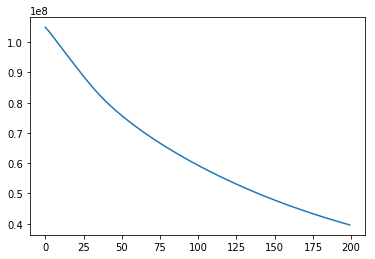

In [12]:
# input place holders 지정
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh) #reuse = tf.get_variable_scope().reuse
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss 계산
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

# optimizer 설정
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

loss_lst = []
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))
        loss_lst.append(step_loss)

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss_lst)

del df[predictY]

test_predict

## Step4. 모델 개선
: 모델 개선을 위해 크게 두가지를 조정
> ### 4-1. input 데이터의 표준화를 다르게 적용  
> ### 4-2. 파라미터 조정

### 4-1. 데이터의 표준화의 방식
: 아래의 두가지의 서로 다른 함수를 적용한 결과 normalize하여 데이터 input하는 것이 정확도가 더 높게 나옴

In [1]:
def MinMaxScaler(data):

    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

def normalize(df):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(df)
    df_scaled = scaler.transform(df)
    return df_scaled

### 4-2. 파라미터 조정
: 아래의 두가지의 서로 다른 함수를 적용한 결과 normalize하여 데이터 input하는 것이 정확도가 더 높게 나옴  
: 해당 모델의 경우 세가지 파라미터를 조정하며 정확도가 높은 모델 찾아냄
> #### hidden_dim : 4~10 사이의 값을 manual하게 부여하며 실험
> #### learning_rate : 0.1~0.5 사이의 값을 manual하게 조정하며 실험
> #### iterations : 500~3000 사이의 값을 loss 값과 iteration을 그래프로 그려서 loss의 최저값 탐색

그 결과 최종적으로 아래와 같은 파라미터를 얻어낼 수 있었다.

In [5]:
# train Parameters
seq_length = 28 # 한 유저의 28일간 데이터를 사용함.
data_dim = 33 # acc_id, day를 제외하고 33개의 피쳐를 가짐
hidden_dim = 10 # 사용자 임의
output_dim = 1 # 출력노드는 1
learning_rate = 0.01
iterations = 2000 # 역전파 횟수